In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## 1. Air passenger data

In [2]:
air_passengers = pd.read_csv("../data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

In [3]:
air_passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


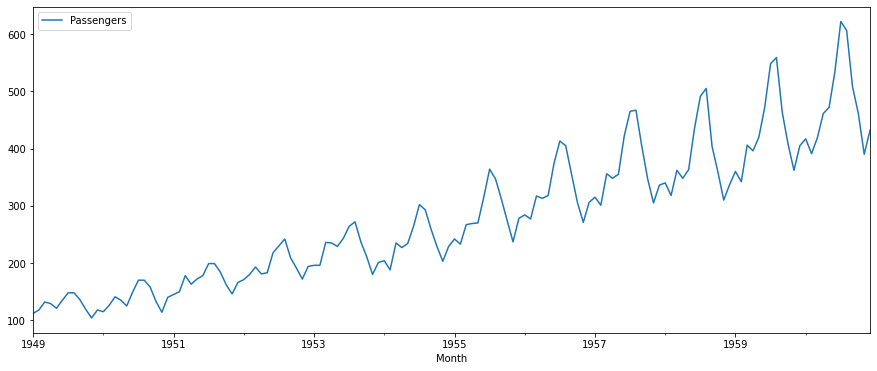

In [4]:
air_passengers.plot();

In [5]:
air_passengers.isna().sum()

Passengers    0
dtype: int64

In [6]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    airpass_test = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(airpass_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in airpass_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return(movingAverage, movingSTD)

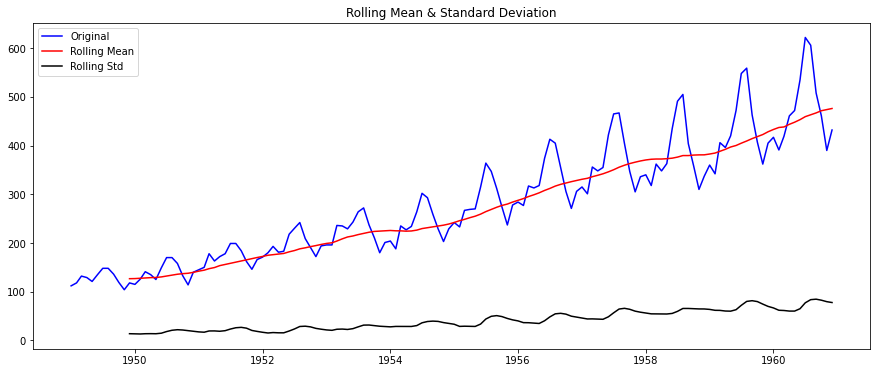

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
_ = test_stationarity(air_passengers)

## 2. Data Transformation to Achieve Stationarity

In [8]:
airpass_log = np.log(air_passengers)

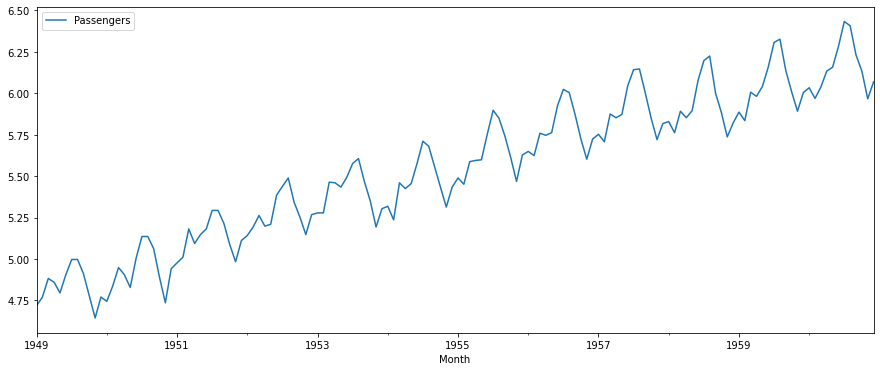

In [9]:
airpass_log.plot();

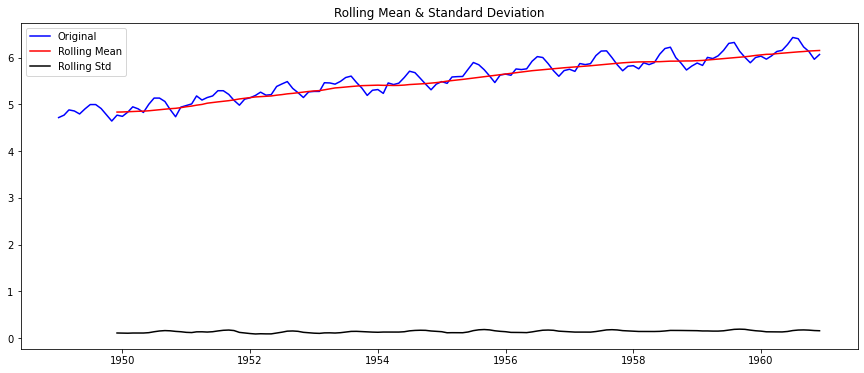

Results of Dickey Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
airpass_log_mean, _ = test_stationarity(airpass_log)

In [11]:
airpass_new = airpass_log - airpass_log_mean

In [12]:
airpass_new.isna().sum()

Passengers    11
dtype: int64

In [13]:
airpass_new.dropna(inplace=True)

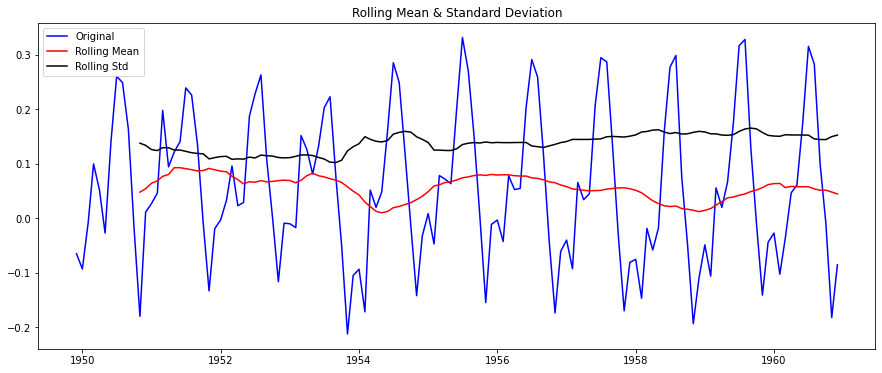

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [14]:
_ = test_stationarity(airpass_new)

#### Time Shift Transformation

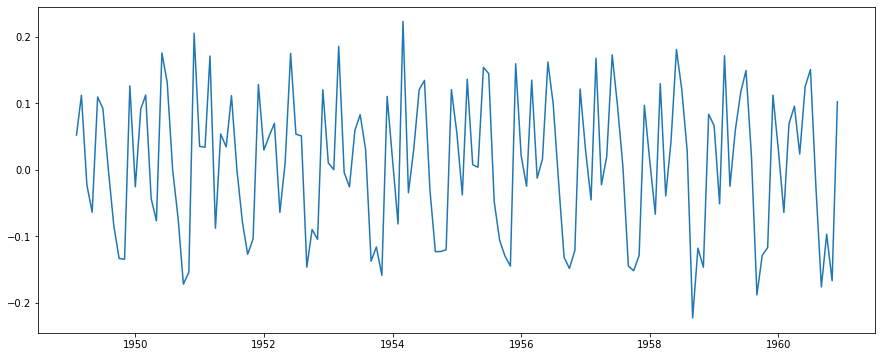

In [15]:
airpass_log_diff = airpass_log - airpass_log.shift()
airpass_log_diff.dropna(inplace=True)
plt.plot(airpass_log_diff)

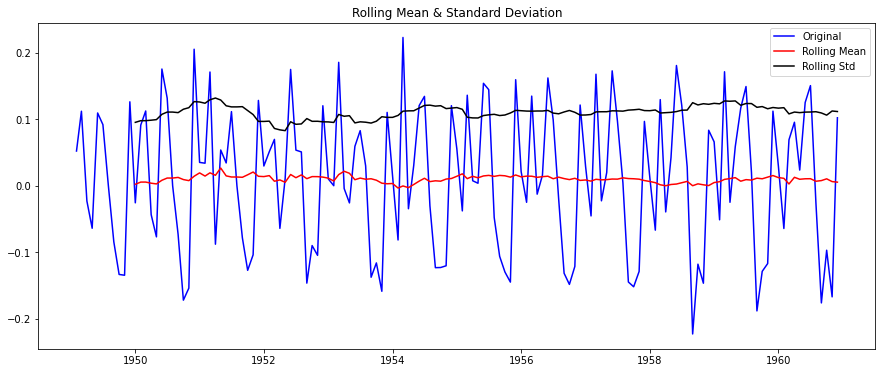

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [16]:
_ = test_stationarity(airpass_log_diff)

#### Seasonal depcomposition

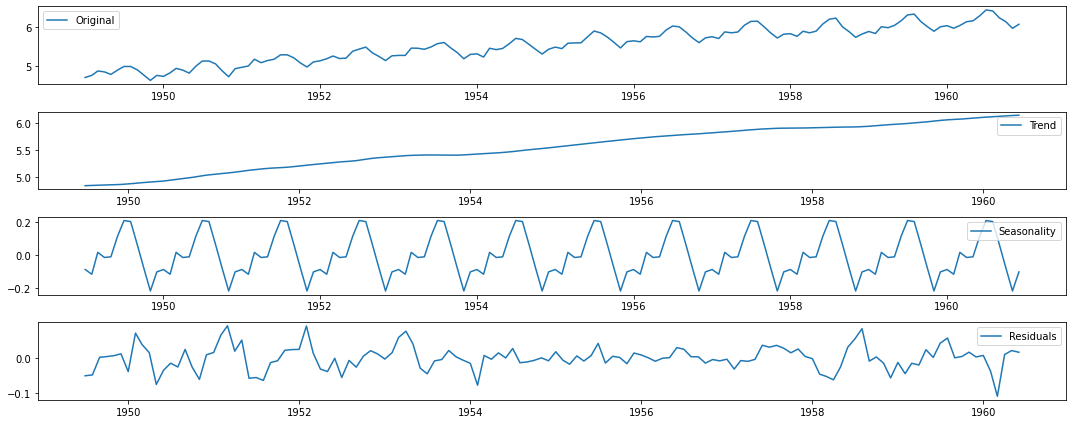

In [17]:
decomposition = seasonal_decompose(airpass_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(airpass_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Plotting ACF & PACF

In [18]:
# acf(airpass_log)

## 3. ARIMA Model

/home/danph/.pyenv/versions/3.8.5/envs/.ml/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/danph/.pyenv/versions/3.8.5/envs/.ml/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/danph/.pyenv/versions/3.8.5/envs/.ml/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


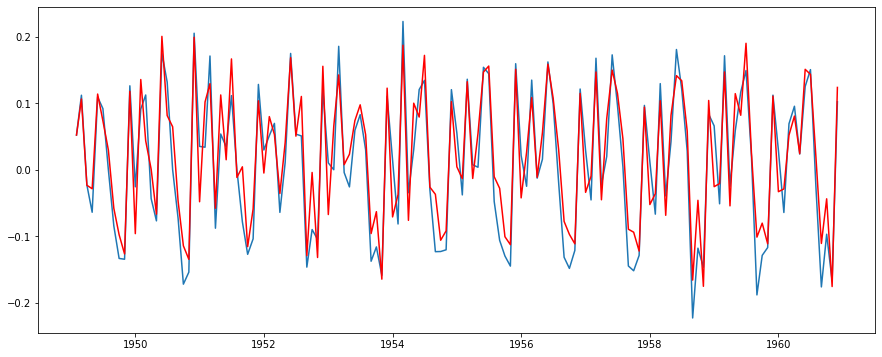

In [19]:
m1 = ARIMA(airpass_log, order=(2,1,2))
rs1 = m1.fit()

plt.plot(airpass_log_diff)
plt.plot(rs1.resid[1:], color='red')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

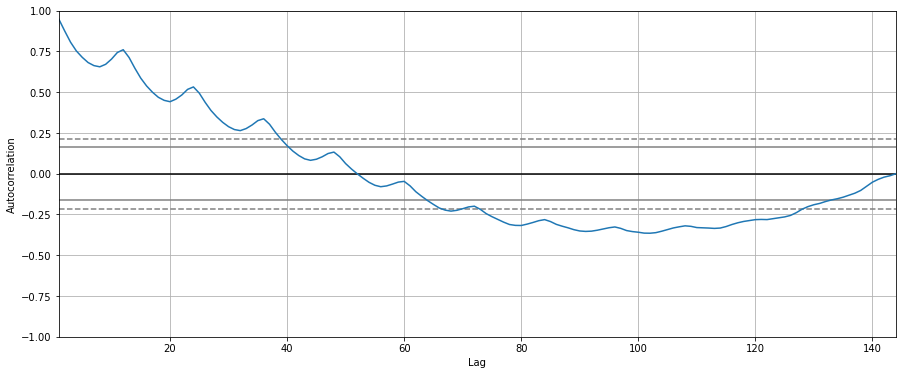

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(air_passengers)

### Prediction

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -693.510
Date:                Wed, 11 May 2022   AIC                           1395.021
Time:                        14:10:50   BIC                           1406.872
Sample:                    01-01-1949   HQIC                          1399.837
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3469      0.092      3.780      0.000       0.167       0.527
ar.L2         -0.1652      0.075     -2.200      0.028      -0.312      -0.018
ar.L3         -0.1602      0.072     -2.237      0.0

/home/danph/.pyenv/versions/3.8.5/envs/.ml/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/danph/.pyenv/versions/3.8.5/envs/.ml/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/danph/.pyenv/versions/3.8.5/envs/.ml/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


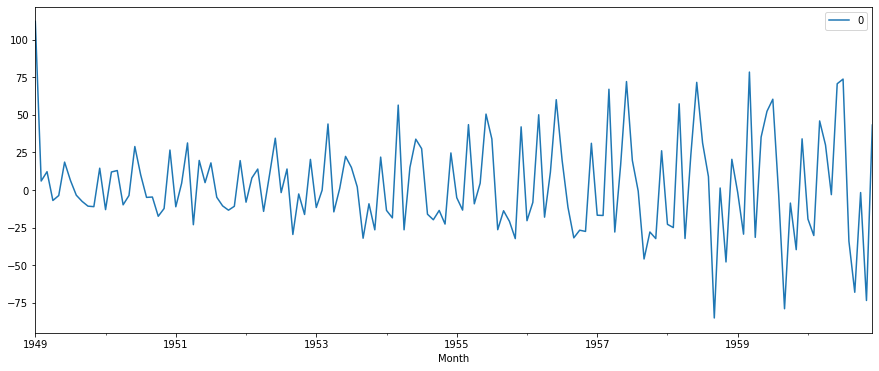

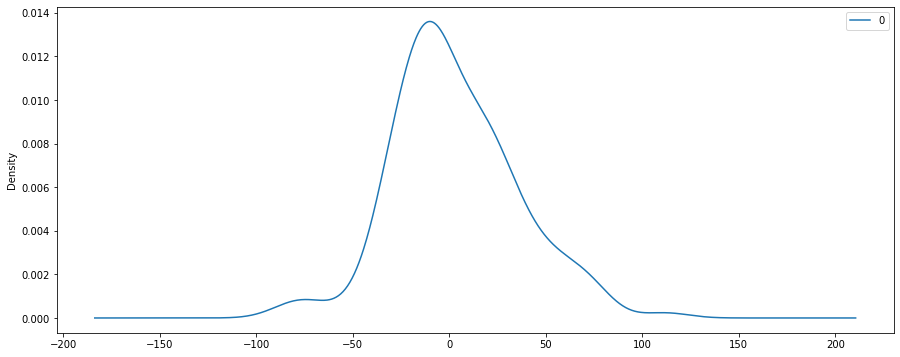

                0
count  144.000000
mean     3.171759
std     32.104145
min    -85.071009
25%    -16.815436
50%     -2.787738
75%     20.749811
max    112.000000


In [21]:
# fit model
model = ARIMA(air_passengers, order=(3,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

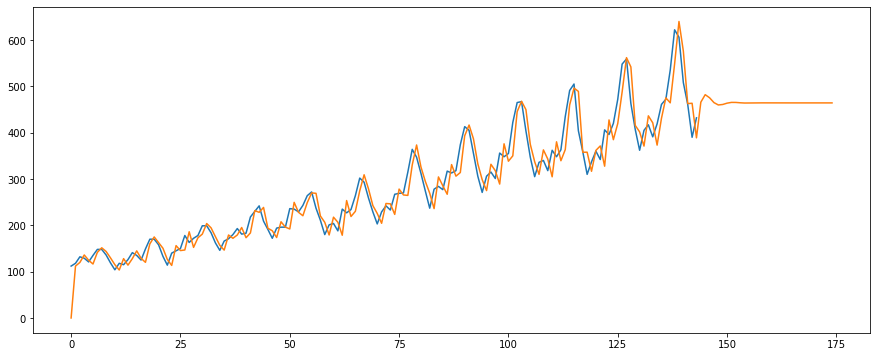

In [22]:
preds = model_fit.predict(start=0, end=len(air_passengers) + 30, dynamic=False)
plt.plot(air_passengers.values)
plt.plot(preds.values)

Test RMSE: 45.563


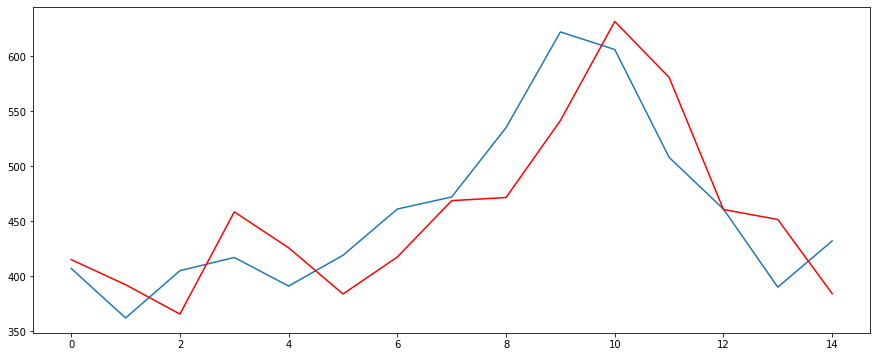

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt


# split into train and test sets
X = air_passengers.values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()